In [8]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA


In [14]:
# Загрузка данных
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
# Функция для обучения SVM и отображения результатов
def train_and_evaluate_svm(kernel):
    print(f"\nРезультаты для ядра {kernel}:")

    # Создание и обучение модели
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)

    # Предсказания
    y_pred = model.predict(X_test)

    # Оценка
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=cancer.target_names))

    # Снижение размерности для визуализации
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Сетка для отображения гиперплоскости
    xx, yy = np.meshgrid(
        np.linspace(X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1, 100),
        np.linspace(X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1, 100)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Получение предсказаний в пространстве PCA
    Z = model.decision_function(pca.inverse_transform(grid))
    Z = Z.reshape(xx.shape)

    # Визуализация гиперплоскости и точек
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.coolwarm, alpha=0.6)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k', linestyles='--')  # Гиперплоскость

    plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='r', label='Malignant', edgecolor='k')
    plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='b', label='Benign', edgecolor='k')

    plt.title(f'SVM Decision Boundary with {kernel} kernel')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()


Результаты для ядра linear:
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

   malignant       0.93      0.95      0.94        43
      benign       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



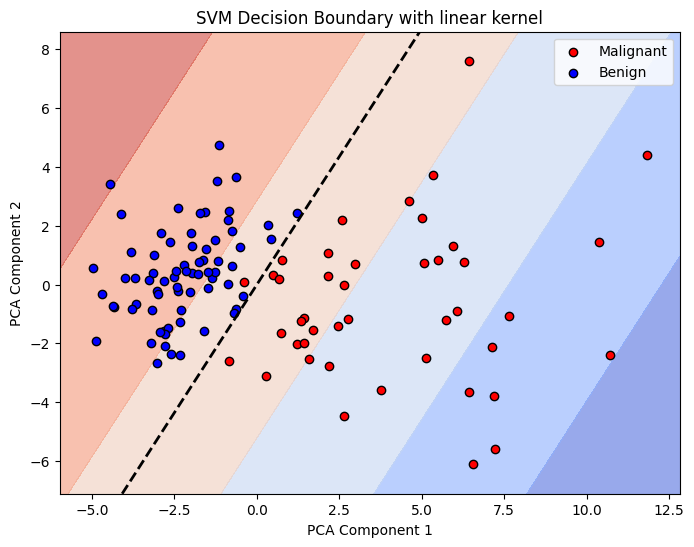


Результаты для ядра rbf:
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        43
      benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



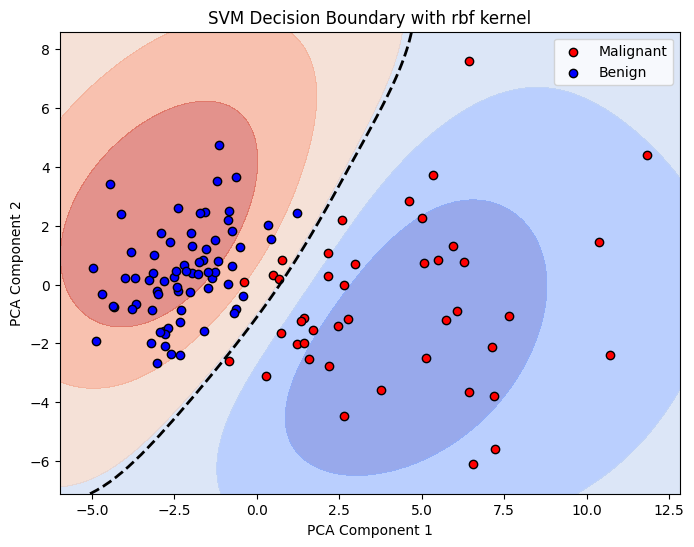

In [18]:
# Обучение и визуализация для разных ядер
for kernel_type in ['linear', 'rbf']:
    train_and_evaluate_svm(kernel_type)

In [22]:
# Функция для оптимизации гиперпараметров с использованием GridSearchCV
def optimize_hyperparameters(kernel):
    print(f"\nОптимизация гиперпараметров для ядра {kernel}:")

    # Определяем модель
    model = SVC(kernel=kernel, random_state=42)

    # Словарь гиперпараметров для поиска
    if kernel == 'linear':
        param_grid = {
            'C': [0.1, 1, 10, 100]  # Пример значений для линейного ядра
        }
    elif kernel == 'rbf':
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': [0.01, 0.1, 1, 10]  # Пример значений для RBF ядра
        }
    
    # GridSearchCV для поиска лучших гиперпараметров
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Лучшие гиперпараметры
    print("Лучшие гиперпараметры:", grid_search.best_params_)

    # Обучение модели с оптимальными гиперпараметрами
    best_model = grid_search.best_estimator_

    # Предсказания и оценка модели
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=cancer.target_names))

    # Визуализация
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Сетка для отображения гиперплоскости
    xx, yy = np.meshgrid(
        np.linspace(X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1, 100),
        np.linspace(X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1, 100)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Получение предсказаний в пространстве PCA
    Z = best_model.decision_function(pca.inverse_transform(grid))
    Z = Z.reshape(xx.shape)

    # Визуализация гиперплоскости и точек
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.coolwarm, alpha=0.6)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k', linestyles='--')  # Гиперплоскость

    plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='r', label='Malignant', edgecolor='k')
    plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='b', label='Benign', edgecolor='k')

    plt.title(f'SVM Decision Boundary with optimized {kernel} kernel')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()


Оптимизация гиперпараметров для ядра linear:
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие гиперпараметры: {'C': 0.1}
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.95      0.98        43
      benign       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



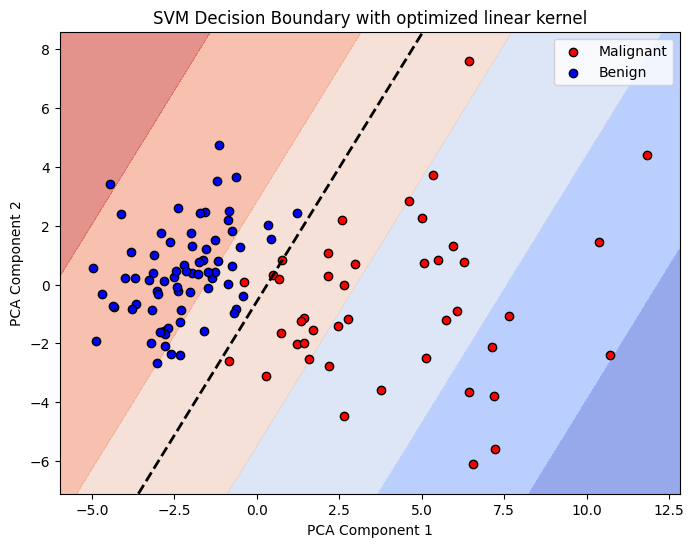


Оптимизация гиперпараметров для ядра rbf:
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие гиперпараметры: {'C': 10, 'gamma': 0.01}
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.95      0.98        43
      benign       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



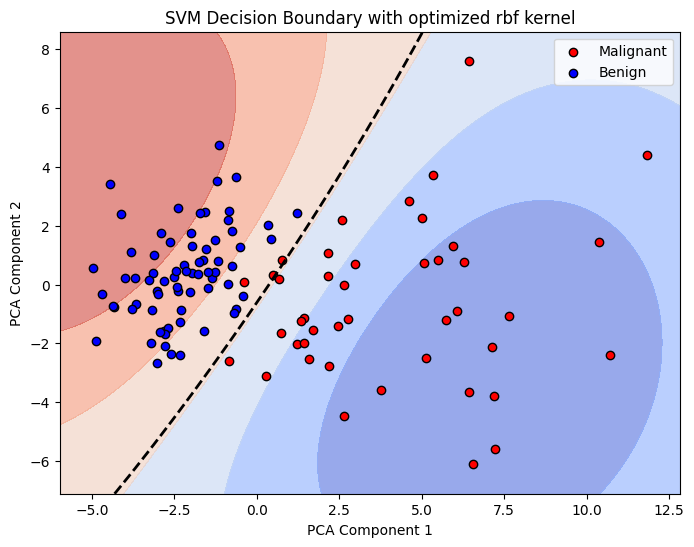

In [23]:
# Вызов функции для оптимизации гиперпараметров
for kernel_type in ['linear', 'rbf']:
    optimize_hyperparameters(kernel_type)